# SageMaker Endpoint (Single Model Endpoint)
---

이제 **SageMaker 모델 호스팅 서비스인 SageMaker 엔드포인트**에 모델을 배포할 준비가 되었습니다. 

SageMaker 엔드포인트는 REST API를 통해 실시간 추론을 수행할 수 있는 완전 관리형 서비스입니다. 기본적으로 분산 컨테이너로 고가용성, 다중 모델 로딩, A/B 테스트를 위한 인프라 환경(EC2, 로드밸런서, 오토스케일링, 모델 아티팩트 로딩 등)이 사전 구축되어 있기에 몇 줄의 코드만으로 Endpoint가 자동으로 생성되기에, 모델을 프로덕션에 빠르게 배포할 수 있습니다.

SageMaker 빌트인 XGBoost를 사용하면 별도의 훈련/추론 스크립트 작성 없이 쉽게 모델을 훈련하고 엔드포인트로 배포할 수 있습니다. 하지만, 여러 가지 요인들로 인해 (예: SHAP 계산을 위한 피쳐 기여값 리턴, 추론값 및 추론 스코어 동시 리턴 등) 커스텀 추론 로직이 필요한 경우, SageMaker 빌트인 XGBoost 대신 SageMaker XGBoost 컨테이너를 사용할 수 있습니다.

이 노트북은 SageMaker XGBoost 컨테이너 상에서, 기본적인 추론 스크립트로 모델을 배포하는 법을 아래와 같은 목차로 진행합니다. 

완료 시간은 **20-30분** 정도 소요됩니다.

### 목차
- [1. Create Model Serving Script](#1.-Create-Model-Serving-Script)
- [2. Deploy a trained model from Amazon S3](#2.-Deploy-a-trained-model-from-Amazon-S3)
    - [2.1. Deploy to Local Environment: XGBoostModel class](#2.1.-Deploy-to-Local-Environment:-XGBoostModel-class)
    - [2.2. Deploy to Local Environment: Model class](#2.2.-Deploy-to-Local-Environment:-Model-class)
    - [2.3. Deploy to Hosting Instance](#2.3.-Deploy-to-Hosting-Instance)

유사한 예제로 실습해 보실 분들은 아래 링크의 샘플 노트북을 참조해 주세요.
- https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_abalone_dist_script_mode.ipynb

<div class="alert alert-warning"><h4>주의</h4><p>
아래 코드 셀은 핸즈온에 필요한 라이브러리들을 설치하고, 주피터 노트북 커널을 셧다운시킵니다. 
    
노트북 커널이 셧다운된다면, 아래 코드 셀에서 <b><font color='darkred'>install_needed = False</font></b>로 변경 후, 코드 셀을 다시 실행해 주세요. 이 작업은 한 번만 수행하면 됩니다. 
</p></div>

In [1]:
import sys, IPython

install_needed = True
#install_needed = False

if install_needed:
    print("===> Installing deps and restarting kernel. Please change 'install_needed = False' and run this code cell again.")
    !{sys.executable} -m pip install -U sagemaker locust pyngrok xgboost==1.3.1
    IPython.Application.instance().kernel.do_shutdown(True)
else:
    import sagemaker, xgboost
    print(f'SageMaker API version={sagemaker.__version__}, XGBoost version={xgboost.__version__}')

===> Installing deps and restarting kernel. Please change 'install_needed = False' and run this code cell again.


In [1]:
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
%load_ext autoreload
%autoreload 2
%store -r
XGB_FRAMEWORK_VERSION = '1.3-1'
DATASET_PATH = '../data/dataset'

<br>

# 0. (Optional) Prepare Your Model
---

혹시 이전 과정을 다 끝내지 못했다면, 아래 코드 셀의 주석을 해제하여 코드 셀을 실행해 주세요.

In [3]:
# import pandas as pd
# import xgboost as xgb
# data = pd.read_csv(f'{DATASET_PATH}/train.csv')
# train = data.drop('fraud', axis=1)
# label = pd.DataFrame(data['fraud'])
# dtrain = xgb.DMatrix(train, label=label)

# params = {'max_depth': 3, 'eta': 0.2, 'objective': "binary:logistic", 'scale_pos_weight': 29}
# num_boost_round = 100
# nfold = 5
# early_stopping_rounds = 10

# cv_results = xgb.cv(
#     params = params,
#     dtrain = dtrain,
#     num_boost_round = num_boost_round,
#     nfold = nfold,
#     early_stopping_rounds = early_stopping_rounds,
#     metrics = ('auc'),
#     stratified = True, # 레이블 (0,1) 의 분포에 따라 훈련 , 검증 세트 분리
#     seed = 0
# )

# print("cv_results: ", cv_results)

# # Select the best score
# print(f"[0]#011train-auc:{cv_results.iloc[-1]['train-auc-mean']}")
# print(f"[1]#011validation-auc:{cv_results.iloc[-1]['test-auc-mean']}")

# metrics_data = {
#     'classification_metrics': {
#         'validation:auc': { 'value': cv_results.iloc[-1]['test-auc-mean']},
#         'train:auc': {'value': cv_results.iloc[-1]['train-auc-mean']}
#     }
# }
      
# model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(cv_results))
# model.save_model("xgboost-model")
# !tar -czvf model.tar.gz xgboost-model && rm xgboost-model   

`Session()`은 AWS 환경에 접속하는 접속 정보와 SageMaker에서 사용하는 리소스를 관리하기 위한 편리한 방법을 제공합니다. 

In [4]:
import boto3
import sagemaker
import json

sess = sagemaker.Session()
sm_session = sagemaker.session.Session()
boto_session = boto3.session.Session()
sm_client = boto3.client("sagemaker")
bucket = sm_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto_session.region_name

print((bucket, role))

('sagemaker-us-west-2-322537213286', 'arn:aws:iam::322537213286:role/service-role/AmazonSageMaker-ExecutionRole-20240103T094982')


### Check Inference Results & Debugging

로컬 엔드포인트나 호스팅 엔드포인트 배포 전, 로컬 환경 상에서 직접 추론을 수행하여 결과를 확인합니다. 

In [5]:
!rm -rf model && mkdir model && cp -r ../lab_1_training/model/* ./model/
!rm -rf ./model/model.tar.gz
# !rm -rf model && mkdir model && tar -xzvf model.tar.gz -C model

In [6]:
import xgboost as xgb
import numpy as np
import pandas as pd

model = xgb.Booster()
model.load_model("model/xgboost-model")

test_df = pd.read_csv(f'{DATASET_PATH}/test.csv')
y_test = test_df.iloc[:, 0].astype('int')
test_df = test_df.drop('fraud', axis=1)
dtest = xgb.DMatrix(test_df)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
y_prob = model.predict(dtest)
y_pred = np.array([1 if e >= 0.5 else 0 for e in y_prob])
y_prob[0], y_pred[0]

(0.4624295, 0)

<br>

# 1. Create Model Serving Script

---

아래 코드 셀은 src 디렉토리에 SageMaker 추론 스크립트를 저장합니다.

#### Option 1.
- `model_fn(model_dir)`: S3의 `model_dir`에 저장된 모델 아티팩트를 로드합니다.
- `input_fn(request_body, content_type)`: 입력 데이터를 전처리합니다. `content_type`은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: `application/x-npy`, `application/json`, `application/csv`등)
- `predict_fn(input_object, model)`: `input_fn(...)`을 통해 들어온 데이터에 대해 추론을 수행합니다.
- `output_fn(prediction, accept_type)`: `predict_fn(...)`에서 받은 추론 결과를 후처리를 거쳐 프론트엔드로 전송합니다.

#### Option 2.
- `model_fn(model_dir)`: S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `transform_fn(model, request_body, content_type, accept_type)`: `input_fn(...), predict_fn(...), output_fn(...)`을 `transform_fn(...)`으로 통합할 수 있습니다.

In [8]:
%%writefile src/inference.py
import os
import time
import json
import pickle as pkl
import numpy as np
from io import BytesIO
import xgboost as xgb
import sagemaker_xgboost_container.encoder as xgb_encoders
NUM_FEATURES = 58


def model_fn(model_dir):
    """
    Deserialize and return fitted model.
    """
    model_file = "xgboost-model"
    model = xgb.Booster()
    model.load_model(os.path.join(model_dir, model_file))
    return model
                     

def input_fn(request_body, request_content_type):
    """
    The SageMaker XGBoost model server receives the request data body and the content type,
    and invokes the `input_fn`.
    Return a DMatrix (an object that can be passed to predict_fn).
    """
    print("Content type: ", request_content_type)
    if request_content_type == "application/x-npy":        
        stream = BytesIO(request_body)
        array = np.frombuffer(stream.getvalue())
        array = array.reshape(int(len(array)/NUM_FEATURES), NUM_FEATURES)
        return xgb.DMatrix(array)
    elif request_content_type == "text/csv":
        return xgb_encoders.csv_to_dmatrix(request_body.rstrip("\n"))
    elif request_content_type == "text/libsvm":
        return xgb_encoders.libsvm_to_dmatrix(request_body)
    else:
        raise ValueError(
            "Content type {} is not supported.".format(request_content_type)
        )
        

def predict_fn(input_data, model):
    """
    SageMaker XGBoost model server invokes `predict_fn` on the return value of `input_fn`.

    Return a two-dimensional NumPy array (predictions and scores)
    """
    start_time = time.time()
    y_probs = model.predict(input_data)
    print("--- Inference time: %s secs ---" % (time.time() - start_time))    
    y_preds = [1 if e >= 0.5 else 0 for e in y_probs] 
    #feature_contribs = model.predict(input_data, pred_contribs=True, validate_features=False)
    return np.vstack((y_preds, y_probs))


def output_fn(predictions, content_type="application/json"):
    """
    After invoking predict_fn, the model server invokes `output_fn`.
    """
    if content_type == "text/csv":
        return ','.join(str(x) for x in outputs)
    elif content_type == "application/json":
        outputs = json.dumps({
            'pred': predictions[0,:].tolist(),
            'prob': predictions[1,:].tolist()
        })        
        
        return outputs
    else:
        raise ValueError("Content type {} is not supported.".format(content_type))

Overwriting src/inference.py


<br>

# 2. Deploy a trained model from Amazon S3
---

SageMaker API의 `Model` 클래스는 훈련한 모델을 서빙하기 위한 모델 아티팩트와 도커 이미지를 정의합니다. 
`Model` 클래스 인스턴스 호출 시 AWS에서 사전 빌드한 도커 이미지 URL을 직접 가져올 수도 있지만, Model의 자식 클래스로(예: `XGBoostModel`, `TensorFlowModel`) 초기화하면 파라메터에 버전만 지정하는 것만으로 편리하게 추론을 수행하는 환경을 정의할 수 있습니다.

### Upload model/source artifacts to S3
압축한 모델 아티팩트를 Amazon S3로 복사합니다.

In [9]:
prefix = 'sm-special-webinar/deploy'
s3_model_path = f's3://{bucket}/{prefix}/model.tar.gz'
!cd model && tar -czvf model.tar.gz xgboost-model && mv model.tar.gz ../
!aws s3 cp model.tar.gz {s3_model_path}

xgboost-model
upload: ./model.tar.gz to s3://sagemaker-us-west-2-322537213286/sm-special-webinar/deploy/model.tar.gz


<br>

## 2.1. Deploy to Local Environment: XGBoostModel class

SageMaker 호스팅 엔드포인트로 배포하기 전에 로컬 모드 엔드포인트로 배포할 수 있습니다. 로컬 모드는 현재 개발 중인 환경에서 도커 컨테이너를 실행하여 SageMaker 프로세싱/훈련/추론 작업을 에뮬레이트할 수 있습니다. 추론 작업의 경우는 Amazon ECR의 딥러닝 프레임워크 기반 추론 컨테이너를 로컬로 가져오고(docker pull) 컨테이너를 실행하여(docker run) 모델 서버를 시작합니다.

https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

```python
local_model_path = f'{os.getcwd()}/model'
ecr_uri = xgb_image_uri

# 도커 컨테이너 구동
!docker run --name xgb -itd -p 8080:8080 -v {local_model_path}:/opt/ml/model {ecr_uri} serve

# 실시간 호출 테스트 
!curl -X POST -H 'Content-Type: application/json' localhost:8080/invocations -d ...

# 도커 컨테이너 중지 및 삭제    
!docker stop xgb
!docker rm xgb
```

참고로 SageMaker SDK에서 `deploy(...)` 메소드로 엔드포인트 배포 시, 인스턴스 타입을 local 이나 local_gpu로 지정하면 위의 과정을 자동으로 수행할 수 있습니다.

```python
# 로컬 엔드포인트 배포
local_predictor = local_model.deploy(initial_instance_count=1, instance_type="local")

# 실시간 호출 테스트 
local_predictor.predict(...)

# 로컬 엔드포인트 삭제 (도커 컨테이너 중지 및 삭제)
local_predictor.delete_endpoint()
```

아래 코드를 보시면 아시겠지만, 지속적으로 업데이트되는 파이썬 버전&프레임워크 버전&트랜스포머 버전에 쉽게 대응할 수 있습니다. AWS에서 관리하고 있는 딥러닝 컨테이너(DLC) 목록을 아래 주소에서 확인해 보세요.
- https://github.com/aws/deep-learning-containers/blob/master/available_images.md

### Create Model

In [10]:
instance_type='local'

In [11]:
from pathlib import Path

# source_dir=f"file://{Path.cwd()}/src"

if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    model_data=f"file://{Path.cwd()}/model.tar.gz"
else:
    sagemaker_session = sagemaker.session.Session()
    model_data=s3_model_path

In [12]:
from sagemaker.xgboost.model import XGBoostModel
from sagemaker.model import Model
from sagemaker.image_uris import retrieve

xgb_model = XGBoostModel(
    model_data=model_data,
    source_dir="src",
    role=role,
    entry_point="inference.py",
    framework_version=XGB_FRAMEWORK_VERSION,
    sagemaker_session=sagemaker_session
)

### Create Endpoint

SageMaker SDK는 `deploy(...)` 메소드를 호출 시, `create-endpoint-config`와 `create-endpoint`를 같이 수행합니다. 좀 더 세분화된 파라메터 조정을 원하면 AWS CLI나 boto3 SDK client 활용을 권장 드립니다.

In [13]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
)

Attaching to njvh13mgg3-algo-1-l668q
njvh13mgg3-algo-1-l668q  | [2024-02-17:08:28:24:INFO] No GPUs detected (normal if no gpus installed)
njvh13mgg3-algo-1-l668q  | [2024-02-17:08:28:24:INFO] No GPUs detected (normal if no gpus installed)
njvh13mgg3-algo-1-l668q  | [2024-02-17:08:28:24:INFO] nginx config: 
njvh13mgg3-algo-1-l668q  | worker_processes auto;
njvh13mgg3-algo-1-l668q  | daemon off;
njvh13mgg3-algo-1-l668q  | pid /tmp/nginx.pid;
njvh13mgg3-algo-1-l668q  | error_log  /dev/stderr;
njvh13mgg3-algo-1-l668q  | 
njvh13mgg3-algo-1-l668q  | worker_rlimit_nofile 4096;
njvh13mgg3-algo-1-l668q  | 
njvh13mgg3-algo-1-l668q  | events {
njvh13mgg3-algo-1-l668q  |   worker_connections 2048;
njvh13mgg3-algo-1-l668q  | }
njvh13mgg3-algo-1-l668q  | 
njvh13mgg3-algo-1-l668q  | http {
njvh13mgg3-algo-1-l668q  |   include /etc/nginx/mime.types;
njvh13mgg3-algo-1-l668q  |   default_type application/octet-stream;
njvh13mgg3-algo-1-l668q  |   access_log /dev/stdout combined;
njvh13mgg3-algo-1-l668q 

### Check Docker

모델 서빙을 위한 도커 컨테이너가 구동되고 있음을 확인할 수 있습니다.

In [14]:
!docker ps

CONTAINER ID   IMAGE                                                                  COMMAND   CREATED          STATUS          PORTS                                       NAMES
ad18870af341   246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.3-1   "serve"   37 seconds ago   Up 36 seconds   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp   njvh13mgg3-algo-1-l668q


### Prediction - SageMaker SDK & text/csv
샘플 데이터에 대해 추론을 수행합니다.

In [15]:
from sagemaker.serializers import CSVSerializer, NumpySerializer
from sagemaker.deserializers import JSONDeserializer
xgb_predictor.serializer = CSVSerializer()
xgb_predictor.deserializer = JSONDeserializer() 

outputs = xgb_predictor.predict(test_df.values[0:4,:])
y_test_sample = y_test[0:4].values
y_pred_sample = outputs['pred']; y_prob_sample = outputs['prob']
y_test_sample, y_pred_sample, y_prob_sample

njvh13mgg3-algo-1-l668q  | [2024-02-17:08:28:59:INFO] No GPUs detected (normal if no gpus installed)
njvh13mgg3-algo-1-l668q  | [2024-02-17:08:28:59:INFO] Installing module with the following command:
njvh13mgg3-algo-1-l668q  | /miniconda3/bin/python3 -m pip install . 
njvh13mgg3-algo-1-l668q  | Processing /opt/ml/code
njvh13mgg3-algo-1-l668q  |   Preparing metadata (setup.py) ... done
njvh13mgg3-algo-1-l668q  | Building wheels for collected packages: inference
njvh13mgg3-algo-1-l668q  |   Building wheel for inference (setup.py) ... done
njvh13mgg3-algo-1-l668q  |   Created wheel for inference: filename=inference-1.0.0-py2.py3-none-any.whl size=22370 sha256=50e0d5024e46c8a10315ecae819a1e387f0bd150e623b4b1905ff70d6e60975b
njvh13mgg3-algo-1-l668q  |   Stored in directory: /home/model-server/tmp/pip-ephem-wheel-cache-c7_v5blj/wheels/3e/0f/51/2f1df833dd0412c1bc2f5ee56baac195b5be563353d111dca6
njvh13mgg3-algo-1-l668q  | Successfully built inference
njvh13mgg3-algo-1-l668q  | Installing coll

(array([0, 0, 0, 0]),
 [0.0, 0.0, 1.0, 1.0],
 [0.4624294936656952,
  0.35229232907295227,
  0.6192859411239624,
  0.5039606690406799])

njvh13mgg3-algo-1-l668q  | 172.18.0.1 - - [17/Feb/2024:08:29:01 +0000] "POST /invocations HTTP/1.1" 200 121 "-" "python-urllib3/1.26.18"


### Prediction - boto3 SDK & application/x-npy

위의 코드 셀처럼 SageMaker SDK의 `predict(...)` 메소드로 추론을 수행할 수도 있지만, 이번에는 boto3의 `invoke_endpoint(...)` 메소드로 추론을 수행해 보겠습니다.
Boto3는 서비스 레벨의 저수준(low-level) SDK로, ML 실험에 초점을 맞춰 일부 기능들이 추상화된 고수준(high-level) SDK인 SageMaker SDK와 달리 SageMaker API를 완벽하게 제어할 수 있습으며, 프로덕션 및 자동화 작업에 적합합니다.

[Note] `invoke_endpoint(...)` 호출을 위한 런타임 클라이언트 인스턴스 생성 시, 로컬 배포 모드에서는`sagemaker.local.LocalSagemakerRuntimeClient(...)`를 호출해야 합니다.

In [16]:
import json

# import boto3
# runtime_client = boto3.client('sagemaker-runtime')
runtime_client = sagemaker.local.LocalSagemakerRuntimeClient()
endpoint_name = xgb_model.endpoint_name
payload=test_df.values[0:4,:].tobytes()
print(f"payload : {payload}")

payload : b'up2\xae[W\xd7@:8\x19\xd7-\xad\xe1@\x00\x00\x00\x00\x00\x00L@\x00\x00\x00\x00\x00\x80]@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00p\x87@\x00\x00\x00\x00\x00p\xa7@\x00\x00\x00\x00p\xef\xf7@\x00\x00\x00\x00\x00p\x9f@\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x06\xc8@\x00\x00\x00\x00\x00\x00"@\x00\x00\x00\x00\x00\x00(@\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00,@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [17]:
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='application/x-npy',
    Accept='application/json',
    Body=payload
)

print(json.loads(response['Body'].read().decode()))

njvh13mgg3-algo-1-l668q  | [2024-02-17:08:29:17:INFO] No GPUs detected (normal if no gpus installed)
njvh13mgg3-algo-1-l668q  | [2024-02-17:08:29:17:INFO] Installing module with the following command:
njvh13mgg3-algo-1-l668q  | /miniconda3/bin/python3 -m pip install . 
njvh13mgg3-algo-1-l668q  | Processing /opt/ml/code
njvh13mgg3-algo-1-l668q  |   Preparing metadata (setup.py) ... done
njvh13mgg3-algo-1-l668q  | Building wheels for collected packages: inference
njvh13mgg3-algo-1-l668q  |   Building wheel for inference (setup.py) ... done
njvh13mgg3-algo-1-l668q  |   Created wheel for inference: filename=inference-1.0.0-py2.py3-none-any.whl size=25963 sha256=2bca1f91f01ab5781e05216008a4531c6db0c7ff726799e7e40c7ef432dc67ca
njvh13mgg3-algo-1-l668q  |   Stored in directory: /home/model-server/tmp/pip-ephem-wheel-cache-cgtuf7i8/wheels/3e/0f/51/2f1df833dd0412c1bc2f5ee56baac195b5be563353d111dca6
njvh13mgg3-algo-1-l668q  | Successfully built inference
njvh13mgg3-algo-1-l668q  | Installing coll

### Prediction - boto3 SDK & text/csv

In [18]:
import io
from io import StringIO
csv_file = io.StringIO()
test_df[0:4].to_csv(csv_file, sep=",", header=False, index=False)
payload = csv_file.getvalue()
print(f"payload : {payload}")

payload : 23901.43250714285,36201.43250714285,56,118,0,1,750,3000,98039,2012,3,3,1,12300,9,12,3,14,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1
29095.295735759966,73695.29573575997,36,71,0,1,750,2650,95307,2016,3,1,1,44600,8,8,3,17,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1
11232.831825505647,25032.83182550565,24,11,1,4,750,3000,98391,2016,2,0,2,13800,2,11,0,21,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
11125.579356093212,25125.57935609321,23,65,0,1,750,3000,91302,2015,2,0,0,14000,8,7,2,7,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0



In [19]:
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='text/csv',
    Accept='application/json',
    Body=payload
)

print(json.loads(response['Body'].read().decode()))

njvh13mgg3-algo-1-l668q  | [2024-02-17:08:29:22:INFO] No GPUs detected (normal if no gpus installed)
njvh13mgg3-algo-1-l668q  | [2024-02-17:08:29:22:INFO] Installing module with the following command:
njvh13mgg3-algo-1-l668q  | /miniconda3/bin/python3 -m pip install . 
njvh13mgg3-algo-1-l668q  | Processing /opt/ml/code
njvh13mgg3-algo-1-l668q  |   Preparing metadata (setup.py) ... done
njvh13mgg3-algo-1-l668q  | Building wheels for collected packages: inference
njvh13mgg3-algo-1-l668q  |   Building wheel for inference (setup.py) ... done
njvh13mgg3-algo-1-l668q  |   Created wheel for inference: filename=inference-1.0.0-py2.py3-none-any.whl size=29734 sha256=1903af3c20c450c29375196eae22aa1612234cdc1c8b7f12ada9b4ef286ee900
njvh13mgg3-algo-1-l668q  |   Stored in directory: /home/model-server/tmp/pip-ephem-wheel-cache-xxgrma5r/wheels/3e/0f/51/2f1df833dd0412c1bc2f5ee56baac195b5be563353d111dca6
njvh13mgg3-algo-1-l668q  | Successfully built inference
njvh13mgg3-algo-1-l668q  | Installing coll

### Local Mode Endpoint Clean-up

In [20]:
xgb_predictor.delete_endpoint()
xgb_model.delete_model()

Gracefully stopping... (press Ctrl+C again to force)


<br>

## 2.2. Deploy to Hosting Instance

로컬 모드에서 충분히 디버깅했으면 실제 호스팅 인스턴스로 배포할 차례입니다. 코드는 거의 동일하며, `instance_type`만 다르다는 점을 주목해 주세요! 

### Create Model

In [21]:
from sagemaker.xgboost.model import XGBoostModel

xgb_model = XGBoostModel(
    model_data=s3_model_path,
    role=role,
    entry_point="src/inference.py",
    framework_version=XGB_FRAMEWORK_VERSION,
)

### Create Endpoint

SageMaker SDK는 `deploy(...)` 메소드를 호출 시, `create-endpoint-config`와 `create-endpoint`를 같이 수행합니다. 좀 더 세분화된 파라메터 조정을 원하면 AWS CLI나 boto3 SDK client 활용을 권장 드립니다.

In [22]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge', 
    wait=False
)

### Wait for the endpoint jobs to complete

엔드포인트가 생성될 때까지 기다립니다. 엔드포인트가 가리키는 호스팅 리소스를 프로비저닝하는 데에 몇 분의 시간이 소요됩니다. 

In [23]:
from IPython.core.display import display, HTML
def make_endpoint_link(region, endpoint_name, endpoint_task):
    endpoint_link = f'<b><a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={region}#/endpoints/{endpoint_name}">{endpoint_task} Review Endpoint</a></b>'   
    return endpoint_link 
        
endpoint_link = make_endpoint_link(region, xgb_predictor.endpoint_name, '[Deploy model from S3]')
display(HTML(endpoint_link))

/tmp/ipykernel_14368/3754662690.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [24]:
sess.wait_for_endpoint(xgb_predictor.endpoint_name, poll=5)

-------------------------!

{'EndpointName': 'sagemaker-xgboost-2024-02-17-08-29-32-733',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:322537213286:endpoint/sagemaker-xgboost-2024-02-17-08-29-32-733',
 'EndpointConfigName': 'sagemaker-xgboost-2024-02-17-08-29-32-733',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.3-1',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:0adf7983eb9f121abfb795cc90b961f81332f823edb08e77de9e3155d1ba1f48',
     'ResolutionTime': datetime.datetime(2024, 2, 17, 8, 29, 33, 790000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 2, 17, 8, 29, 33, 222000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 2, 17, 8, 31, 47, 99000, tzinfo=tzlocal()),
 'ResponseMetadata'

### Prediction - SageMaker SDK & text/csv
샘플 데이터에 대해 추론을 수행합니다.

In [25]:
from sagemaker.serializers import CSVSerializer, NumpySerializer
from sagemaker.deserializers import JSONDeserializer
xgb_predictor.serializer = CSVSerializer()
xgb_predictor.deserializer = JSONDeserializer() 

outputs = xgb_predictor.predict(test_df.values[0:4,:])
y_test_sample = y_test[0:4].values
y_pred_sample = outputs['pred']; y_prob_sample = outputs['prob']
y_test_sample, y_pred_sample, y_prob_sample

(array([0, 0, 0, 0]),
 [0.0, 0.0, 1.0, 1.0],
 [0.4624294936656952,
  0.35229232907295227,
  0.6192859411239624,
  0.5039606690406799])

### Prediction - boto3 SDK & application/x-npy

위의 코드 셀처럼 SageMaker SDK의 `predict(...)` 메소드로 추론을 수행할 수도 있지만, 이번에는 boto3의 `invoke_endpoint(...)` 메소드로 추론을 수행해 보겠습니다.
Boto3는 서비스 레벨의 저수준(low-level) SDK로, ML 실험에 초점을 맞춰 일부 기능들이 추상화된 고수준(high-level) SDK인 SageMaker SDK와 달리 SageMaker API를 완벽하게 제어할 수 있습으며, 프로덕션 및 자동화 작업에 적합합니다.

In [26]:
runtime_client = boto3.client('sagemaker-runtime')
endpoint_name = xgb_model.endpoint_name
payload = test_df.values[0:4,:].tobytes()

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='application/x-npy',
    Accept='application/json',
    Body=payload
)

print(json.loads(response['Body'].read().decode()))

{'pred': [0.0, 0.0, 1.0, 1.0], 'prob': [0.4624294936656952, 0.35229232907295227, 0.6192859411239624, 0.5039606690406799]}


### Prediction - boto3 SDK & text/csv

In [27]:
import io
from io import StringIO
csv_file = io.StringIO()
test_df[0:4].to_csv(csv_file, sep=",", header=False, index=False)
payload = csv_file.getvalue()

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='text/csv',
    Accept='application/json',
    Body=payload
)

print(json.loads(response['Body'].read().decode()))

{'pred': [0.0, 0.0, 1.0, 1.0], 'prob': [0.4624294936656952, 0.35229232907295227, 0.6192859411239624, 0.5039606690406799]}


### Evaluation (Not Required)

테스트셋에 대해 성능 평가를 수행합니다. 다만, 일반적인 경우 테스트셋은 정답 데이터가 포함되어 있지 않다는 점 유념해 주세요.

In [28]:
outputs = xgb_predictor.predict(test_df.values)
y_pred = outputs['pred']; y_prob = outputs['prob']

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
print(f"{classification_report(y_true=y_test, y_pred=y_pred)}")

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)     
print(cm)

mse = mean_squared_error(y_test, y_pred)
std = np.std(y_test - y_pred)
report_dict = {
    "regression_metrics": {
        "mse": {
            "value": mse,
            "standard_deviation": std
        },
    },
}
report_dict

              precision    recall  f1-score   support

           0       0.99      0.50      0.66       967
           1       0.06      0.91      0.11        33

    accuracy                           0.51      1000
   macro avg       0.53      0.70      0.39      1000
weighted avg       0.96      0.51      0.65      1000

[[483 484]
 [  3  30]]


{'regression_metrics': {'mse': {'value': 0.487,
   'standard_deviation': 0.5056075553232966}}}

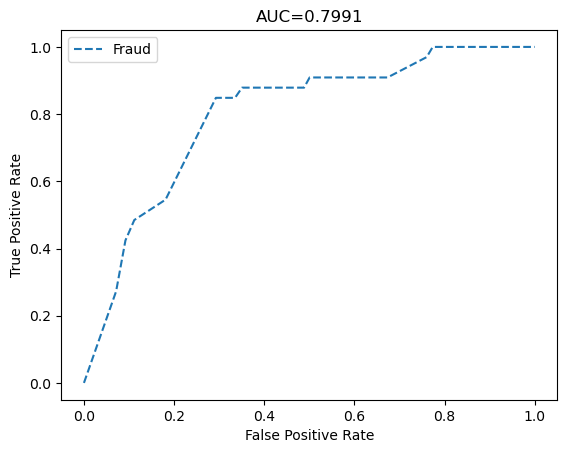

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

pyplot.plot(fpr, tpr, linestyle='--', label='Fraud')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title(f'AUC={auc:.4f}')
pyplot.legend()
pyplot.show()

다음 모듈에서 재사용할 변수들을 저장합니다. 만약 다음 모듈로 진행하지 않는다면 아래 섹션의 코드 셀을 주석 해제 후 실행해 주세요.

In [31]:
%store endpoint_name test_df s3_path

Stored 'endpoint_name' (str)
Stored 'test_df' (DataFrame)


UsageError: Unknown variable 's3_path'


### (Optional) Endpoint Clean-up

In [32]:
# xgb_predictor.delete_endpoint()
# xgb_model.delete_model()